![logo](../../../LogoLine_horizon_C3S.png)

<div class="alert alert-block alert-warning">
Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch
</div>

# Comparing sea ice concentration products to the sea ice edge product

Production date: 14-04-2025

Produced by: Timothy Williams, Nansen Environment and Remote Sensing Center

## 🌍 Use case: Assessing the uncertainty of sea ice concentration products

## ❓ Quality assessment question
**How do the sea ice concentration products compare to the sea ice edge product?**

## 📢 Quality assessment statement
```{admonition} These are the key outcomes of this assessment
:class: note
We find that both sea ice concentration products generally produce a lower ice extent than the ice edge product, but that the bias and IIEE (Integrated Ice Edge Error) are lower for the SSMIS (Special Sensor Microwave Imager/Sounder) products than the AMSR  (Advanced Microwave Scanning Radiometer) product. This is consistent with the results from the notebook on the assessment of climate change on the satellite sea ice concentration products, which showed that the SSMIS product had a higher extent than the AMSR. Comparing the Arctic and the Antarctic, the signs of the metrics are the same but the sizes of the discrepancies are larger in Antarctica. The differences between these products give one estimate of the uncertainty in the sea ice concentration products and the extents derived from them.
```

## 📋 Methodology
We first take the [<span style="color:blue">sea ice concentration dataset</span>](https://cds.climate.copernicus.eu/datasets/satellite-sea-ice-concentration?tab=overview), which has two CDR (Climate Data Record) products from EUMETSAT (European Organisation for the Exploitation of Meteorological Satellites) OSI SAF (Ocean and Sea Ice Satellite Application Facility):
- SSMIS (1979-2020)
- AMSR (2003-2017)

Then we compare it to the [<span style="color:blue">sea ice edge and type dataset</span>](https://cds.climate.copernicus.eu/datasets/satellite-sea-ice-edge-type?tab=overview), and use the product:
- Sea ice edge CDR (1978-2020)

To compare the two products we first convert the sea ice concentration (SIC) to an ice/water classification according to the criteria used to create the ice edge product which is SIC > 30%. We then compare the classification from each SIC product to the classification from the sea ice edge product, which is determined by considering all passive microwave SIC products available (including others not in the CADS). The comparison is done by calculating areas $A_{\rm over}$ (area of the grid cells with ice in the SIC product but no ice in the ice edge product) and $A_{\rm under}$ (area of the grid cells with no ice in the SIC product but ice in the ice edge product). The final metrics used are the "bias", defined as $A_{\rm over} - A_{\rm under}$, and the IIEE (integrated ice edge error, or the total area where the classification from the SIC product disagrees with the sea ice edge product), defined as $A_{\rm over} + A_{\rm under}$.

The "Analysis and results" section is structured as follows:

**[](satellite_satellite-sea-ice-concentration_intercomparison_q02:section-1)**

**[](satellite_satellite-sea-ice-concentration_intercomparison_q02:section-2)**

**[](satellite_satellite-sea-ice-concentration_intercomparison_q02:section-3)**

## 📈 Analysis and results

(satellite_satellite-sea-ice-concentration_intercomparison_q02:section-1)=
### 1. Parameters, requests and functions definition
- Define parameters and formulate requests for downloading with the EQC toolbox.
- Define functions to be applied to process and reduce the size of the downloaded data.
- Define functions to post-process and visualize the data.

#### 1.1 Import libraries
Import the required libraries, including the EQC toolbox.

In [1]:
import warnings

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

plt.style.use("seaborn-v0_8-notebook")
warnings.filterwarnings("ignore", module="cf_xarray")

#### 1.2 Set parameters
Set the time period to cover with `start_year` and `stop_year`.
Also specify `regrid_kwargs`, which are options to use for interpolating the sea ice concentration product to the grid used for the sea ice edge product.

In [2]:
# Time
start_year = 1979
stop_year = 2020

# Regridding options
regrid_kwargs = {
    "method": "nearest_s2d",
    "periodic": True,
    "ignore_degenerate": True,
}

#### 1.3 Define requests
Define the requests for downloading the sea ice concentration data using the EQC toolbox.

In [3]:
conc_request = {
    "origin": "eumetsat_osi_saf",
    "cdr_type": "cdr",
    "variable": "all",
    "version": "v3",
    "temporal_aggregation": "daily",
}

collection_id = 'satellite-sea-ice-concentration'

request_dict = {
    "SSMIS": download.update_request_date(
        conc_request | {"sensor": "ssmis"},
        start=f"{max(start_year, 1979)}-01",
        stop=f"{min(stop_year, 2020)}-12",
        stringify_dates=True,
    ),
    "AMSR": download.update_request_date(
        conc_request | {"sensor": "amsr"},
        start=f"{max(start_year, 2002)}-01",
        stop=f"{min(stop_year, 2017)}-12",
        stringify_dates=True,
    ),
}

#### 1.4 Functions for creating the time series of differences between the datasets
- `add_bounds` is a small function to add longitude and latitude bounds if we are using conservative interpolation.
- `interpolate_to_siedge_grid` interpolates a sea ice concentration dataset to the sea ice edge grid.
- `get_interpolated_data` is a wrapper function which modifies some dimensions and attributes and calls `interpolate_to_siedge_grid` if requested.
- `get_siedge_data` loads the sea ice edge data. It is also transformed with `get_interpolated_data` but without interpolation since the concentration data is being transformed onto its grid.
- `compare_siconc_vs_siedge` calculates the metrics measuring the differences between the sea ice concentration dataset and the sea ice edge one.
- `compute_siconc_siedge_time_series` is the function that is called by `c3s_eqc_automatic_quality_control.download.download_and_transform`. It calls `get_siedge_data`, `get_interpolated_data`, and creates the final time series with `compare_siconc_vs_siedge`.

In [4]:
def add_bounds(obj):
    return obj.cf.add_bounds(
        coord for coord in ("longitude", "latitude") if coord not in obj.cf.bounds
    )


def interpolate_to_siedge_grid(obj, region, **regrid_kwargs):
    # Lat 360 to 180
    if (obj["longitude"] > 180).any():
        with xr.set_options(keep_attrs=True):
            obj["longitude"] = (obj["longitude"] + 180) % 360 - 180

    collection_id = "satellite-sea-ice-edge-type"
    request = {
        "region": region,
        "variable": "sea_ice_edge",
        "cdr_type": "cdr",
        "version": "3_0",
        "format": "zip",
        "year": "2002",
        "month": "06",
        "day": "01",
    }
    grid_out = download.download_and_transform(collection_id, request).drop_dims("time")

    if regrid_kwargs["method"].startswith("conservative"):
        obj = add_bounds(obj)
        grid_out = add_bounds(grid_out)

    return diagnostics.regrid(obj, grid_out, **regrid_kwargs)


def get_interpolated_data(ds, region, **regrid_kwargs):
    ds = ds.drop_dims(set(ds.dims) & {"vertices", "bnds"})
    if regrid_kwargs:
        ds = interpolate_to_siedge_grid(ds, region, **regrid_kwargs)
    ds["time"].attrs["long_name"] = "time"
    return ds


def get_siedge_data(time, region):
    year_start = time.dt.year.min().values
    year_stop = time.dt.year.max().values

    collection_id = "satellite-sea-ice-edge-type"
    edge_request = {
        "format": "zip",
        "region": region,
        "variable": "sea_ice_edge",
        "cdr_type": "cdr",
        "version": "3_0",
    }
    edge_request = download.update_request_date(
        edge_request,
        start=f"{max(year_start, 1978)}-01",
        stop=f"{min(year_stop, 2020)}-12",
        stringify_dates=True,
    )

    ds = download.download_and_transform(
        collection_id,
        edge_request,
        chunks={"year": 1},
        transform_func=get_interpolated_data,
        transform_func_kwargs={"region": region},
    )
    return ds.sel(time=slice(time.min(), time.max()))


def compare_siconc_vs_siedge(ds, ds_edge):
    ds = ds.convert_calendar("standard", align_on="date")

    # grid cell area of sea ice edge grid
    dims = ("xc", "yc")
    dx = np.abs(np.diff(ds[dims[0]][:2].values))[0]
    grid_cell_area = (dx ** 2) * 1.0e-6  # 10^6 km2

    # get sea ice concentration and convert to ice/water classification
    sic = ds.cf["sea_ice_area_fraction"]
    if sic.attrs.get("units", "") == "(0 - 1)":
        sic *= 100
    sic_threshold = 30
    sic_class = xr.where(sic >= sic_threshold, 2, 1) # 1 = open water, 2 = ice
    proj_var = sic.grid_mapping
    dataarrays = {}
    
    # get ice edge classification and compare to the one from SIC
    edge_class = ds_edge.cf["sea_ice_classification"] # 1 = open water, 2 = miz, 3 = pack
    over = (sic_class == 2) * (edge_class == 1)
    under = (sic_class == 1) * (edge_class >= 2)
    
    # Compute common output
    over = grid_cell_area * over.sum(dim=dims)
    under = grid_cell_area * under.sum(dim=dims)
    dataarrays["iiee"] = over + under
    dataarrays["iiee"].attrs = {
        "standard_name": "integrated_ice_edge_error",
        "units": "$10^6$km$^2$",
        "long_name": "Integrated ice edge error",
    }

    dataarrays["siextent_bias"] = over - under
    dataarrays["siextent_bias"].attrs = {
        "standard_name": "sea_ice_extent_bias",
        "units": "$10^6$km$^2$",
        "long_name": "Sea ice extent bias",
    }
    return xr.Dataset(dataarrays)


def compute_siconc_siedge_time_series(ds, region, **regrid_kwargs):
    # Sea ice edge data
    ds_edge = get_siedge_data(ds["time"], region=region)

    # Interpolate sea ice concentration data onto the sea ice edge grid
    ds_interpolated = get_interpolated_data(ds, region=region, **regrid_kwargs)

    # Compare the sea ice concentration product with the sea ice edge classification
    return compare_siconc_vs_siedge(ds_interpolated, ds_edge)

#### 1.5 Postprocessing and plotting functions
- `rearrange_year_vs_dayofyear` changes the dataset from having a single time dimension to having two: the year and the Julian day of the year.
- `make_subplot` makes one plot of a variable with a different line for each year (shown with a legend if there are not too many lines; otherwise it is shown with a colorbar), and with the $x$ axis being the Julian day of the year.
- `plot_against_dayofyear` calls `make_subplot` for each of the extent bias and the integrated ice edge error (IIEE).

In [5]:
def rearrange_year_vs_dayofyear(ds):
    new_dims = ("year", "dayofyear")
    ds = ds.convert_calendar("noleap")
    ds = ds.assign_coords(
        {dim: ("time", getattr(ds["time"].dt, dim).values) for dim in new_dims}
    )
    return ds.set_index(time=new_dims).unstack("time")


def make_subplot(ax, ds_doy, vname, color_map, **kwargs):
    num_years = len(ds_doy.year)
    for i,year in enumerate(ds_doy.year):
        da = ds_doy.sel(year=year)[vname].squeeze()
        ax.plot(da.dayofyear, da.values, color=color_map(i/(num_years-1)), label=year.item(), **kwargs)


def plot_against_dayofyear(ds, region, cmap = "viridis"):
    num_years = len(ds.year)
    color_map = plt.get_cmap(cmap, num_years)
    use_legend = num_years <= 7
    if use_legend:
        alpha = .75
        figsize=(7,7)
    else:
        alpha = .5
        figsize = (8.75,7)

    var_names = ["siextent_bias", "iiee"]
    fig, axs = plt.subplots(len(var_names), 1, sharex=True, figsize=figsize)
    ylabels = {"iiee": "IIEE", "siextent_bias": "Sea ice edge bias"}
    ylims = {
        "northern_hemisphere": {"iiee": [.1,.7], "siextent_bias": [-.5,.5]},
        "southern_hemisphere": {"iiee": [.1,1.25], "siextent_bias": [-1.,.5]},
    }

    for vname, ax in zip(var_names, axs.flatten()):
        make_subplot(ax, ds.sel(region=region), vname, color_map, alpha=alpha)
        ax.set_ylabel(f"{ylabels[vname]} [{ds[vname].units}]")
        ax.set_ylim(ylims[region][vname])

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
    ax.xaxis.set_tick_params(rotation=45)
    if use_legend:
        ax.legend()
        return
    
    cbar = fig.colorbar(
        plt.cm.ScalarMappable(
            cmap=cmap,
            norm=plt.Normalize(vmin=min(ds.year), vmax=max(ds.year)),
        ),
        ax=axs.ravel().tolist(),
    )
    cbar.set_label('Year')

(satellite_satellite-sea-ice-concentration_intercomparison_q02:section-2)=
### 2. Download and transform
This is where the data is downloaded, transformed with `compute_siconc_siedge_time_series`, and saved to disk by the EQC toolbox. If the code is rerun the transformed data is loaded from the disk.
It is then post-processed with `rearrange_year_vs_dayofyear` to be used by `plot_against_dayofyear`.

In [ ]:
download_kwargs = {
    "drop_variables": (
        "raw_ice_conc_values",
        "total_standard_error",
        "smearing_standard_error",
        "algorithm_standard_error",
        "status_flag",
    ),
}

datasets_compare_edge = {}
datasets = []
for product, requests in request_dict.items():
    for region in [
        "northern_hemisphere",
        "southern_hemisphere",
    ]:
        print(f"{product = }, {region = }")
        regional_requests = [request | {"region": region} for request in requests]
        ds = download.download_and_transform(
            collection_id, regional_requests,
            transform_func=compute_siconc_siedge_time_series,
            transform_func_kwargs=regrid_kwargs | {"region": region},
            chunks={"year": 1},
            **download_kwargs,
        )
        datasets.append(ds.expand_dims(region=[region]).compute())
    datasets_compare_edge[product] = xr.concat(datasets, "region")
    datasets = []

datasets_compare_edge_vs_doy = {v: rearrange_year_vs_dayofyear(ds) for v, ds in datasets_compare_edge.items()}

(satellite_satellite-sea-ice-concentration_intercomparison_q02:section-3)=
### 3. Results

#### 3.1 Arctic sea ice edge

Below we plot the difference in ice edge for the Arctic between the ice edge product and the ice mask (sea ice concentration >30%) derived from the SSMIS sea ice concentration CDR, which covers the period 1979 - 2015. In winter this product has a negative bias compared to the ice edge product (between 0 - 0.2 million km$^2$), while in summer it has a positive bias (between 0 - 0.4 million km$^2$). The IIEE is generally between 0.2 - 0.3 million km$^2$ in late winter, being between 0.1 - 0.3 million km$^2$ earlier in winter with a minimum around October. The IIEE is highest in summer (between 0.3 - 0.6 million km$^2$).

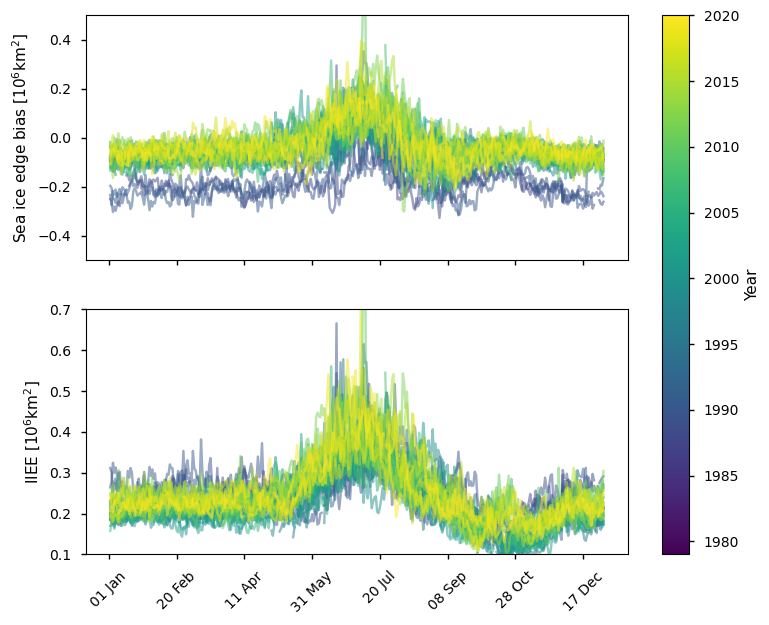

In [7]:
plot_against_dayofyear(datasets_compare_edge_vs_doy['SSMIS'], region="northern_hemisphere")

Below we plot the difference in ice edge for the Arctic between the ice edge product and the ice mask (sea ice concentration >30%) derived from the AMSR sea ice concentration CDR, which covers the period 2002 - 2017. This product has a consistent negative bias compared to the ice edge product (between 0 - 0.4 million km$^2$). In late winter (January - April) it is nearly constant around -0.2 million km$^2$, but it is more variable at other times of the year. The IIEE is generally between 0.25 - 0.35 million km$^2$ in late winter, being between 0.15 - 0.35 million km$^2$ earlier in winter with a minimum around October. The IIEE is highest in summer (between 0.3 - 0.6 million km$^2$).

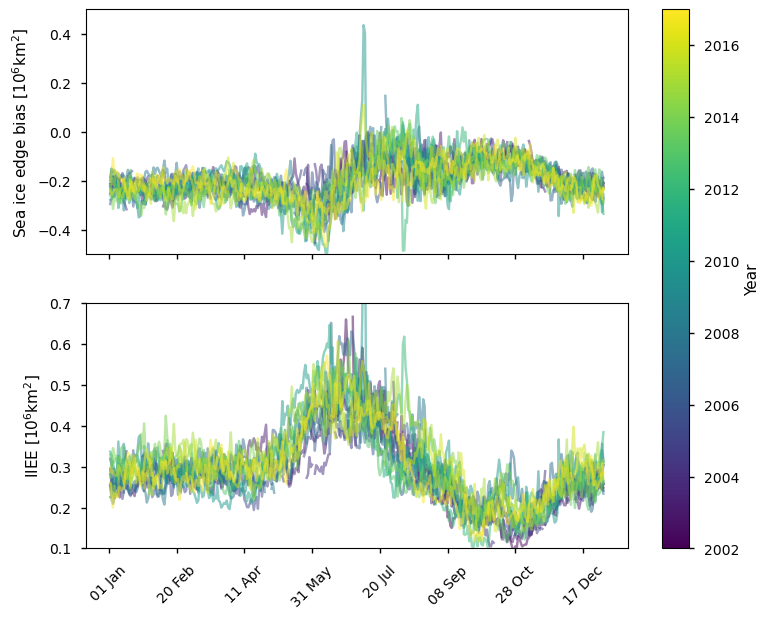

In [8]:
plot_against_dayofyear(datasets_compare_edge_vs_doy['AMSR'], region="northern_hemisphere")

#### 3.2 Antarctic sea ice edge

Below we plot the difference in ice edge for the Antarctic between the ice edge product and the ice mask (sea ice concentration >30%) derived from the SSMIS sea ice concentration CDR, which covers the period 1979 - 2015. It is biased lower than the ice edge product by an amount between 0 and 0.5 million km$^2$, with the difference (and the spread of differences) being greatest in the summer. The IIEE is also greater in summer (between 0.4 - 0.9 million km$^2$), while it is between 0.2 - 0.4 million km$^2$ in winter. The IIEE also has more spread in summer than in winter.

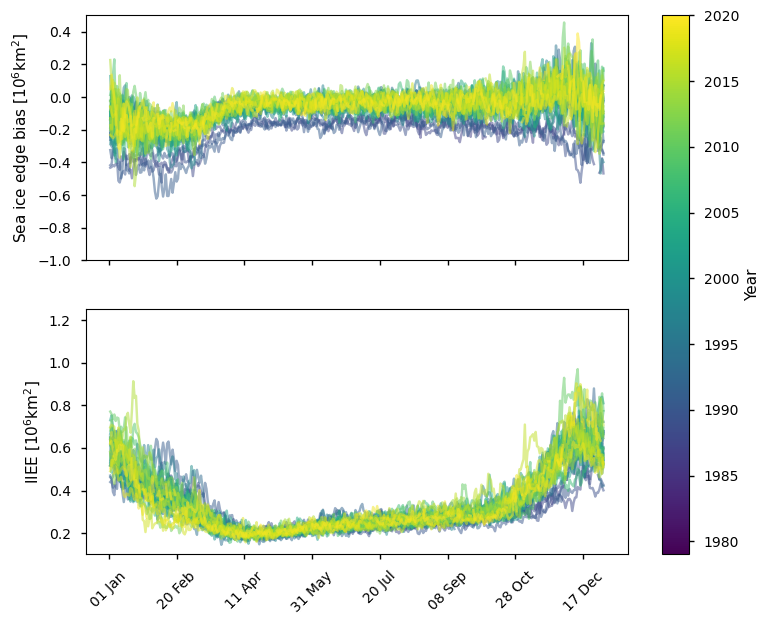

In [9]:
plot_against_dayofyear(datasets_compare_edge_vs_doy['SSMIS'], region="southern_hemisphere")

Below we plot the difference in ice edge for the Antarctic between the ice edge product and the ice mask (sea ice concentration >30%) derived from the AMSR sea ice concentration CDR, which covers the period 2002-2017. It is biased lower than the ice edge product by an amount between 0.25 and 0.75 million km$^2$, with the difference (and the spread of differences) being greatest in the summer. The IIEE is also greater in summer (between 0.6 - 1.1 million km$^2$), while it is between 0.2 - 0.5 million km$^2$ in winter. The IIEE also has more spread in summer than in winter.

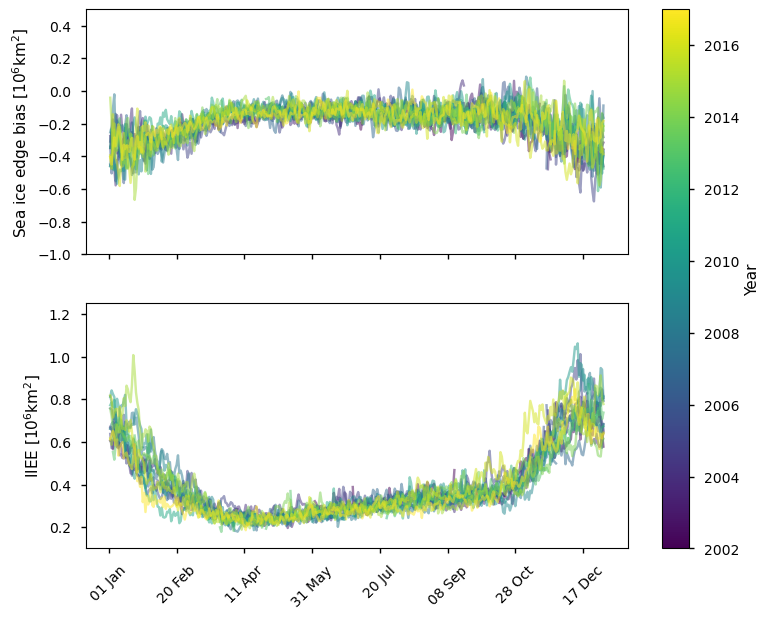

In [10]:
plot_against_dayofyear(datasets_compare_edge_vs_doy['AMSR'], region="southern_hemisphere")

## ℹ️ If you want to know more

### Key resources

Introductory sea ice materials:
- [<span style="color:blue">Role of sea ice in the climate</span>](https://www.epa.gov/climate-indicators/climate-change-indicators-arctic-sea-ice)
- [<span style="color:blue">Observing sea ice with satellites</span>](https://www.metoffice.gov.uk/research/climate/cryosphere-oceans/sea-ice/measure)

Code libraries used:
* [<span style="color:blue">C3S EQC custom functions</span>](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [<span style="color:blue">B-Open</span>](https://www.bopen.eu/)

### References

1. Ivanova, N., Pedersen, L. T., Tonboe, R. T., Kern, S., Heygster, G., Lavergne, T., Sørensen, A., Saldo, R., Dybkjær, G., Brucker, L., & Shokr, M. (2015). Inter-comparison and evaluation of sea ice algorithms: towards further identification of challenges and optimal approach using passive microwave observations. The Cryosphere, 9(5), 1797-1817, [<span style="color:blue">https://doi.org/10.5194/tc-9-1797-2015</span>](https://doi.org/10.5194/tc-9-1797-2015).

2. Comiso, J. C., Cavalieri, D. J., Parkinson, C. L., & Gloersen, P. (1997). Passive microwave algorithms for sea ice concentration: A comparison of two techniques. Remote sensing of Environment, 60(3), 357-384, [<span style="color:blue">https://doi.org/10.1016/S0034-4257(96)00220-9</span>](https://doi.org/10.1016/S0034-4257(96)00220-9).

3. Buckley, E. M., Horvat, C., & Yoosiri, P. (2024). Sea Ice Concentration Estimates from ICESat-2 Linear Ice Fraction. Part 1: Multi-sensor Comparison of Sea Ice Concentration Products. EGUsphere, 2024, 1-19, [<span style="color:blue">https://doi.org/10.5194/egusphere-2024-3861</span>](https://doi.org/10.5194/egusphere-2024-3861).